# Sentiment Analysis with BERT

> TL;DR In this tutorial, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the amazing Transformers library by Hugging Face!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Let's get started!

In [ ]:
!nvidia-smi

Fri Feb 12 18:44:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [ ]:
#import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install -qq transformers==3

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.19.5
pandas 1.1.5
torch 1.7.0+cu101
transformers 3.0.0


In [ ]:
# Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load data
path = "drive/MyDrive/dataset_en_train.json"
df = pd.read_json(path, lines = True).rename(columns={'stars':'star_rating'})
df = df.sample(frac=1).reset_index(drop=True)
df = df.head(5000)
df.head()

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category
0,en_0522546,product_en_0681589,reviewer_en_0687817,3,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden
1,en_0612910,product_en_0295449,reviewer_en_0312138,2,"The leg openings are a little small, but other...",Crap,en,apparel
2,en_0983065,product_en_0295095,reviewer_en_0927618,4,Really cute mug. I would have given 5 stars if...,Four Stars,en,kitchen
3,en_0206761,product_en_0563487,reviewer_en_0936741,2,Well it’s looks and feels okay but it most cer...,Lies!!,en,industrial_supplies
4,en_0510474,product_en_0704805,reviewer_en_0417600,1,"Very, very thin, you can bend them with you fi...",Thin and bendable :(,en,pet_products


In [ ]:
df.shape

(5000, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         5000 non-null   object
 1   product_id        5000 non-null   object
 2   reviewer_id       5000 non-null   object
 3   star_rating       5000 non-null   int64 
 4   review_body       5000 non-null   object
 5   review_title      5000 non-null   object
 6   language          5000 non-null   object
 7   product_category  5000 non-null   object
dtypes: int64(1), object(7)
memory usage: 312.6+ KB


Great, no missing values in the score and review texts! Do we have class imbalance?

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


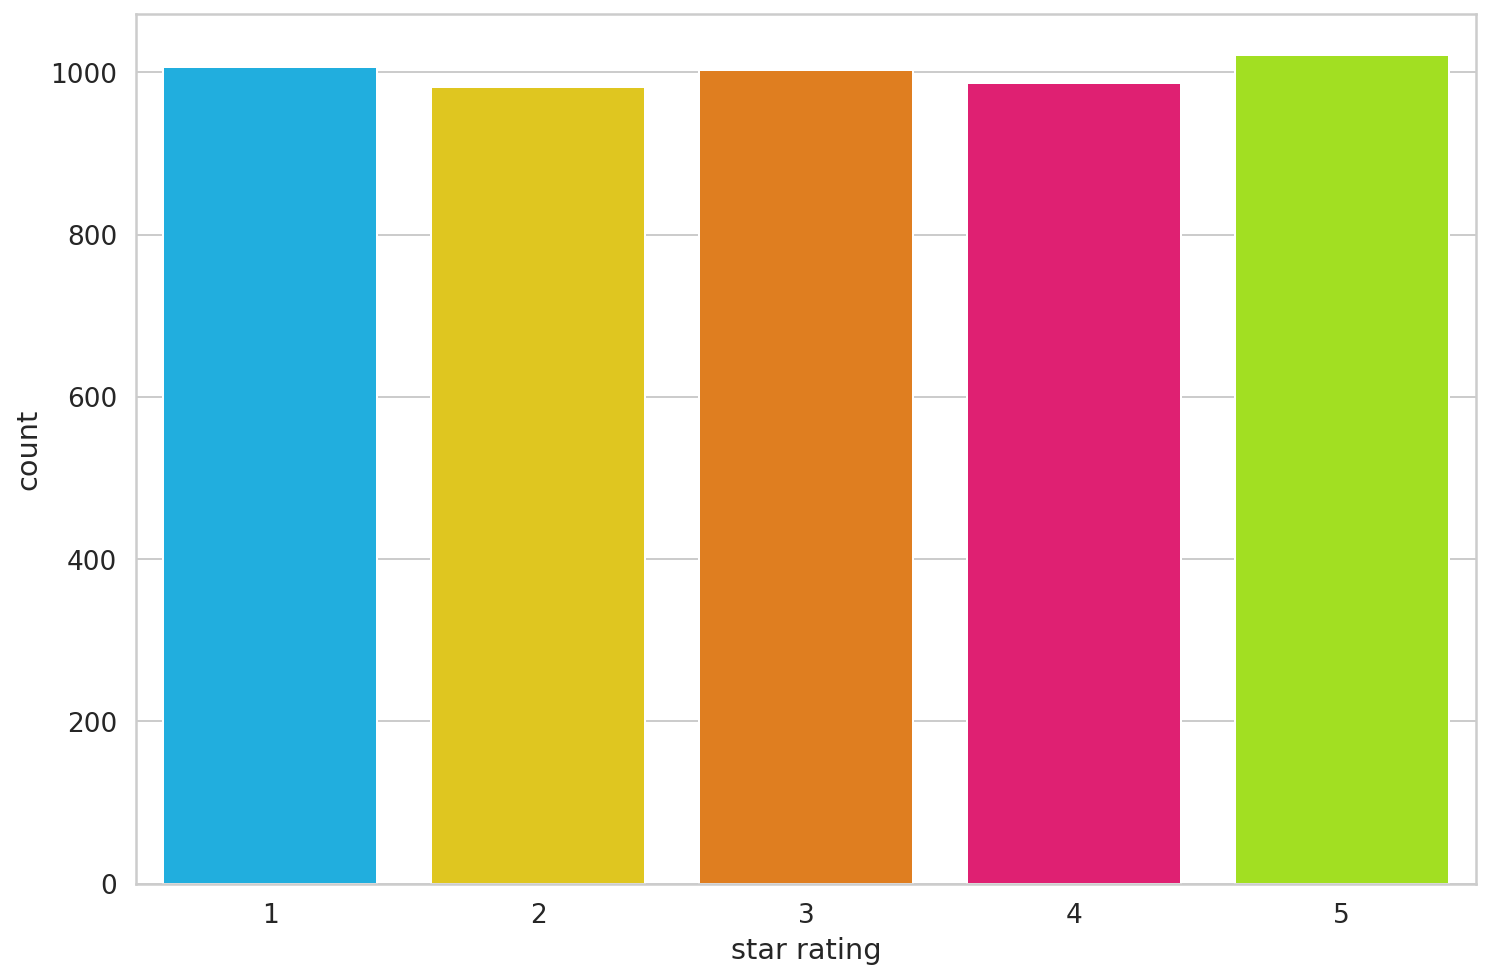

In [ ]:
sns.countplot(df.star_rating)
plt.xlabel('star rating');

In [ ]:
class_names = ['1','2','3','4','5'] 

## Data Preprocessing

You might already know that Machine Learning models don't work with raw text. You need to convert text to numbers (of some sort). BERT requires even more attention (good one, right?). Here are the requirements: 

- Add special tokens to separate sentences and do classification
- Pass sequences of constant length (introduce padding)
- Create array of 0s (pad token) and 1s (real token) called *attention mask*

The Transformers library provides (you've guessed it) a wide variety of Transformer models (including BERT). It works with TensorFlow and PyTorch! It also includes prebuild tokenizers that do the heavy lifting for us!


In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

> You can use a cased and uncased version of BERT and tokenizer. I've experimented with both. The cased version works better. Intuitively, that makes sense, since "BAD" might convey more sentiment than "bad".

Let's load a pre-trained [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

We'll use this text to understand the tokenization process:

In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

Some basic operations can convert the text to tokens and tokens to unique integers (ids):

In [ ]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


### Special Tokens

`[SEP]` - marker for ending of a sentence


`[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification

There is also a special token for padding:

BERT understands tokens that were in the training set. Everything else can be encoded using the `[UNK]` (unknown) token:

All of that work can be done using the [`encode_plus()`](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer.encode_plus) method:

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  truncation=True,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

The token ids are now stored in a Tensor and padded to a length of 32:

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

The attention mask has the same length:

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

We can inverse the tokenization to have a look at the special tokens:

### Choosing Sequence Length

BERT works with fixed-length sequences. We'll use a simple strategy to choose the max length. Let's store the token length of each review:

In [ ]:
token_lens = []

for txt in df.review_body:
  tokens = tokenizer.encode(txt, max_length=512, truncation=True)
  token_lens.append(len(tokens))

and plot the distribution:

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


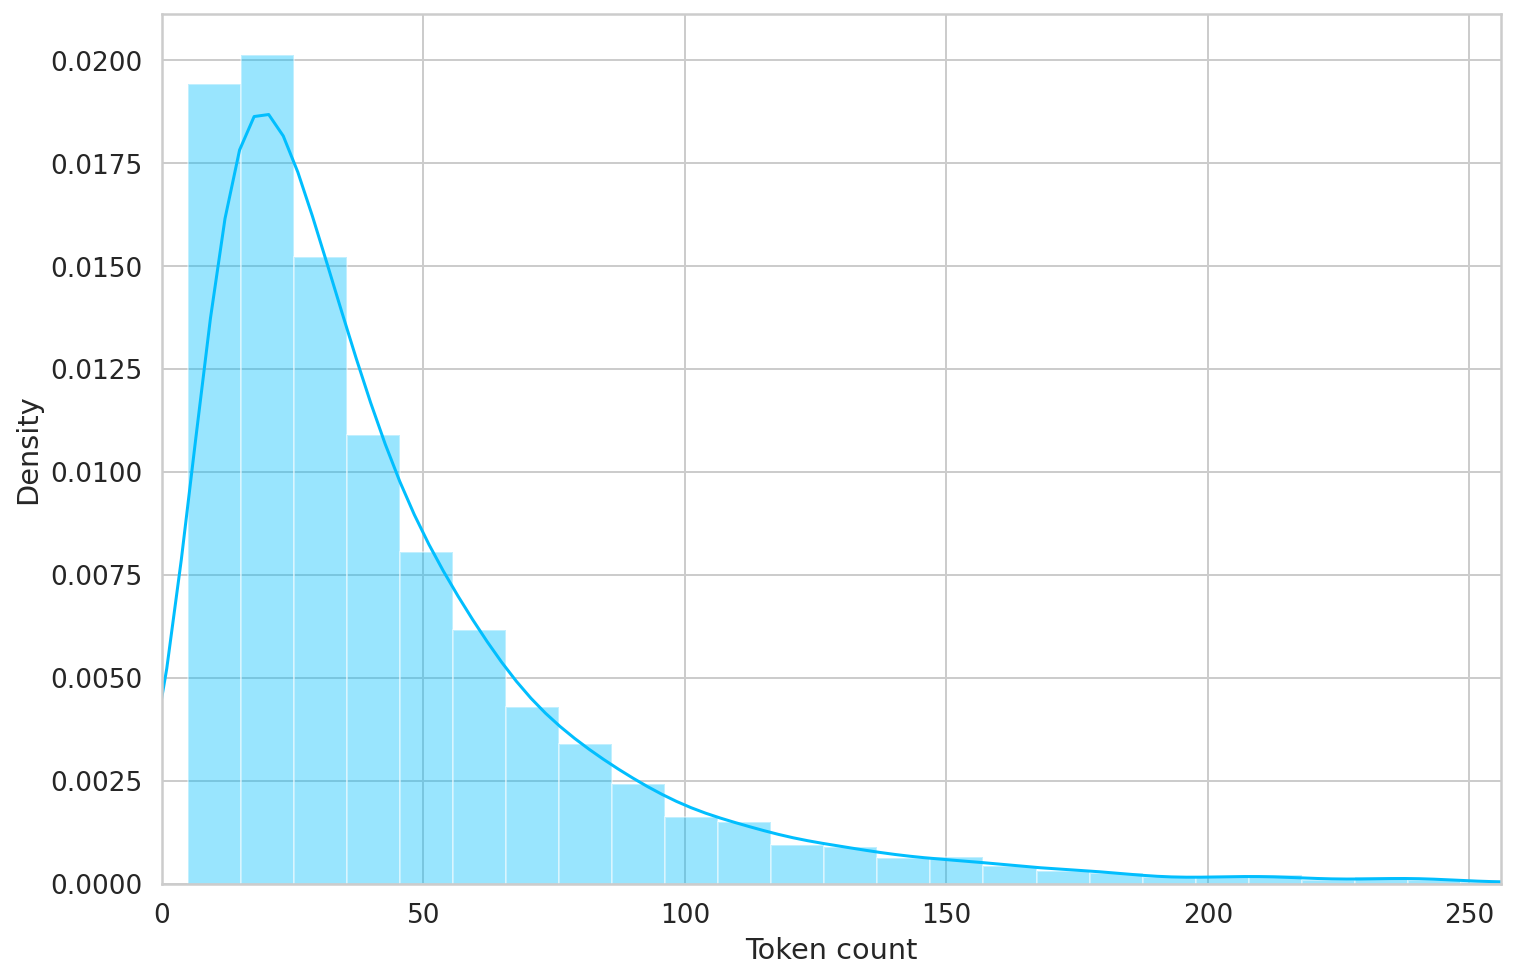

In [ ]:
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

Most of the reviews seem to contain less than 128 tokens, but we'll be on the safe side and choose a maximum length of 160.

In [ ]:
MAX_LEN = 160

We have all building blocks required to create a PyTorch dataset. Let's do it:

In [ ]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      truncation=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

The tokenizer is doing most of the heavy lifting for us. We also return the review texts, so it'll be easier to evaluate the predictions from our model. Let's split the data:

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
cats=sorted(df_train.star_rating.unique())
dic_cat=dict(zip(cats,range(len(cats))))
 
df_train.loc[:,'star_rating']=df_train.star_rating.apply(lambda x: dic_cat[x])
df_test.loc[:,'star_rating']=df_test.star_rating.apply(lambda x: dic_cat[x])
df_val.loc[:,'star_rating']=df_val.star_rating.apply(lambda x: dic_cat[x])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
df_train.shape, df_val.shape, df_test.shape

((4500, 8), (250, 8), (250, 8))

In [ ]:
sorted(df_train.star_rating.unique())

[0, 1, 2, 3, 4]

We also need to create a couple of data loaders. Here's a helper function to do it:

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.review_body.to_numpy(),
    targets=df.star_rating.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Let's have a look at an example batch from our training data loader:

In [ ]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [ ]:
#for d in train_data_loader:
   # print(len(d['input_ids']))
    #print(d['input_ids'])
    #print(d['attention_mask'])
    #print(d['targets'])

## Sentiment Classification with BERT and Hugging Face

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task you might want to use [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) or something else. 

But who cares, right? We're *hardcore*! We'll use the basic [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and build our sentiment classifier on top of it. Let's load the model:

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

And try to use it on the encoding of our sample text:

In [ ]:
last_hidden_state, pooled_output = bert_model(
 input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

The `last_hidden_state` is a sequence of hidden states of the last layer of the model. Obtaining the `pooled_output` is done by applying the [BertPooler](https://github.com/huggingface/transformers/blob/edf0582c0be87b60f94f41c659ea779876efc7be/src/transformers/modeling_bert.py#L426) on `last_hidden_state`:

In [ ]:
last_hidden_state.shape

torch.Size([1, 32, 768])

We have the hidden state for each of our 32 tokens (the length of our example sequence). But why 768? This is the number of hidden units in the feedforward-networks. We can verify that by checking the config:

In [ ]:
bert_model.config.hidden_size

768



You can think of the `pooled_output` as a summary of the content, according to BERT. Albeit, you might try and do better. Let's look at the shape of the output:

In [ ]:
pooled_output.shape

torch.Size([1, 768])

We can use all of this knowledge to create a classifier that uses the BERT model:

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

Our classifier delegates most of the heavy lifting to the BertModel. We use a dropout layer for some regularization and a fully-connected layer for our output. Note that we're returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work.

This should work like any other PyTorch model. Let's create an instance and move it to the GPU:

In [ ]:
model = SentimentClassifier(5) ## definimos numero de clases len(class_names) = 5 
model = model.to(device)

We'll move the example batch of our training data to the GPU:

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 160])
torch.Size([16, 160])


To get the predicted probabilities from our trained model, we'll apply the softmax function to the outputs:

In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1) ## 5 targets como hemos definido, y la probabilidad de cada una para cada input id 

tensor([[0.2850, 0.1191, 0.2924, 0.1367, 0.1668],
        [0.3119, 0.0859, 0.2269, 0.1166, 0.2586],
        [0.1870, 0.1011, 0.4193, 0.0989, 0.1937],
        [0.4160, 0.0835, 0.2417, 0.1140, 0.1448],
        [0.3726, 0.1029, 0.1561, 0.0963, 0.2721],
        [0.2197, 0.0990, 0.3516, 0.1038, 0.2259],
        [0.2530, 0.0836, 0.2511, 0.0850, 0.3273],
        [0.1840, 0.1761, 0.3001, 0.1180, 0.2218],
        [0.2143, 0.1023, 0.4097, 0.1072, 0.1665],
        [0.1396, 0.1214, 0.2850, 0.1439, 0.3101],
        [0.2332, 0.0911, 0.2528, 0.0996, 0.3233],
        [0.2607, 0.1370, 0.2708, 0.0862, 0.2453],
        [0.3405, 0.0543, 0.2311, 0.1722, 0.2019],
        [0.3056, 0.1022, 0.2070, 0.1222, 0.2630],
        [0.2507, 0.1106, 0.2915, 0.1831, 0.1641],
        [0.1957, 0.1195, 0.2549, 0.1139, 0.3161]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)

In [ ]:
len(class_names)

5

In [ ]:
model(input_ids, attention_mask)

tensor([[ 0.3945, -0.7462,  0.7144, -0.4586,  0.0726],
        [ 0.8229, -0.1238,  0.3913, -0.3848,  0.2949],
        [ 0.6004, -0.4406,  0.3920, -0.4833,  0.2341],
        [ 0.7859, -0.5229,  0.3643, -0.5774,  0.7781],
        [ 0.3333, -0.4036,  0.3610,  0.0793,  0.3784],
        [ 0.1355, -1.0122,  0.4805,  0.4484,  0.4774],
        [ 0.5772, -0.2037,  0.9375, -0.7171,  0.0188],
        [ 0.7295, -0.5392,  0.1761, -0.2741,  0.6945],
        [ 0.6462, -0.7448,  0.6669,  0.0241,  0.2641],
        [ 0.2083, -0.7077,  0.6945, -0.1068,  0.2257],
        [ 0.4288, -1.0862,  0.9120, -0.5538,  0.3021],
        [-0.1284, -0.3863,  0.6726, -0.0104,  0.1126],
        [ 0.7760, -0.7648,  0.9242, -0.9674,  0.9135],
        [ 0.7433, -0.3339,  0.8723, -0.7299, -0.0671],
        [-0.0068, -0.5145,  0.3127, -0.1945, -0.5096],
        [ 1.0320, -0.6147,  1.1293, -0.0962,  0.3816]], device='cuda:0',
       grad_fn=<AddmmBackward>)

### Training

To reproduce the training procedure from the BERT paper, we'll use the [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) optimizer provided by Hugging Face. It corrects weight decay, so it's similar to the original paper. We'll also use a linear scheduler with no warmup steps:

In [ ]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)
#loss_fn = nn.MSELoss().to(device)


How do we come up with all hyperparameters? The BERT authors have some recommendations for fine-tuning:

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

We're going to ignore the number of epochs recommendation but stick with the rest. Note that increasing the batch size reduces the training time significantly, but gives you lower accuracy.

Let's continue with writing a helper function for training our model for one epoch:

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader: 
    input_ids = d["input_ids"].to(device)         
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask) ## devuelve un vector con las probablidades asociadas a las 5 clases

    _, preds = torch.max(outputs, dim=1)  ## cogemos el valor con max probabilidad a lo largo de la primera dimension
    loss = loss_fn(outputs, targets)  ## lo usamos para calcular el loss

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #para evitar exploding gradient
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

Training the model should look familiar, except for two things. The scheduler gets called every time a batch is fed to the model. We're avoiding exploding gradients by clipping the gradients of the model using [clip_grad_norm_](https://pytorch.org/docs/stable/nn.html#clip-grad-norm).

Let's write another one that helps us evaluate the model on a given data loader:

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

Using those two, we can write our training loop. We'll also store the training history:

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 1.287346267742468 accuracy 0.41933333333333334
Val   loss 1.045681107789278 accuracy 0.54

Epoch 2/5
----------
Train loss 0.9255410332417657 accuracy 0.5948888888888889
Val   loss 1.0468933954834938 accuracy 0.532

Epoch 3/5
----------
Train loss 0.6512449412798205 accuracy 0.7475555555555556
Val   loss 1.1984352767467499 accuracy 0.54

Epoch 4/5
----------
Train loss 0.437495647883373 accuracy 0.8446666666666667
Val   loss 1.3904776759445667 accuracy 0.5760000000000001

Epoch 5/5
----------
Train loss 0.31015846727693336 accuracy 0.9044444444444445
Val   loss 1.540296196937561 accuracy 0.5720000000000001

CPU times: user 13min 34s, sys: 7min 31s, total: 21min 6s
Wall time: 21min 13s


Note that we're storing the state of the best model, indicated by the highest validation accuracy.

Whoo, this took some time! We can look at the training vs validation accuracy:

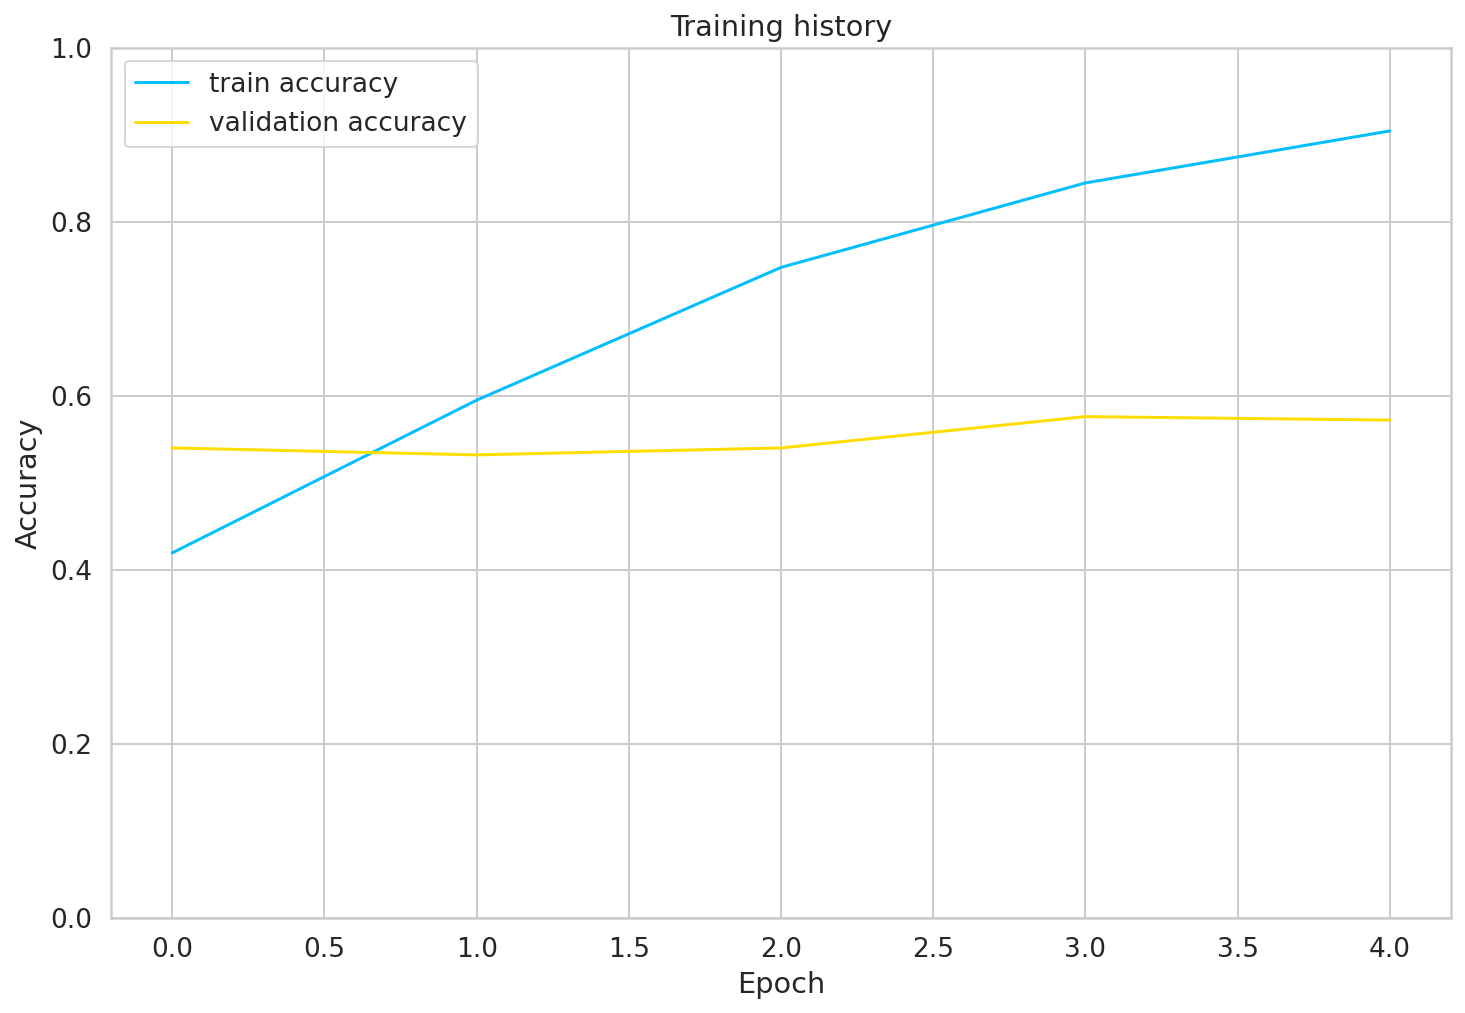

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

The training accuracy starts to approach 100% after 10 epochs or so. You might try to fine-tune the parameters a bit more, but this will be good enough for us.

Don't want to wait? Uncomment the next cell to download my pre-trained model:

## Evaluation

So how good is our model on predicting sentiment? Let's start by calculating the accuracy on the test data:

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.548

The accuracy is about 1% lower on the test set. Our model seems to generalize well.

We'll define a helper function to get the predictions from our model:

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

This is similar to the evaluation function, except that we're storing the text of the reviews and the predicted probabilities (by applying the softmax on the model outputs):

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

Let's have a look at the classification report

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

           1       0.70      0.59      0.64        44
           2       0.47      0.52      0.50        50
           3       0.47      0.47      0.47        53
           4       0.40      0.44      0.42        45
           5       0.73      0.69      0.71        58

    accuracy                           0.55       250
   macro avg       0.55      0.54      0.55       250
weighted avg       0.56      0.55      0.55       250



Looks like it is really hard to classify neutral (3 stars) reviews. And I can tell you from experience, looking at many reviews, those are hard to classify.

We'll continue with the confusion matrix:

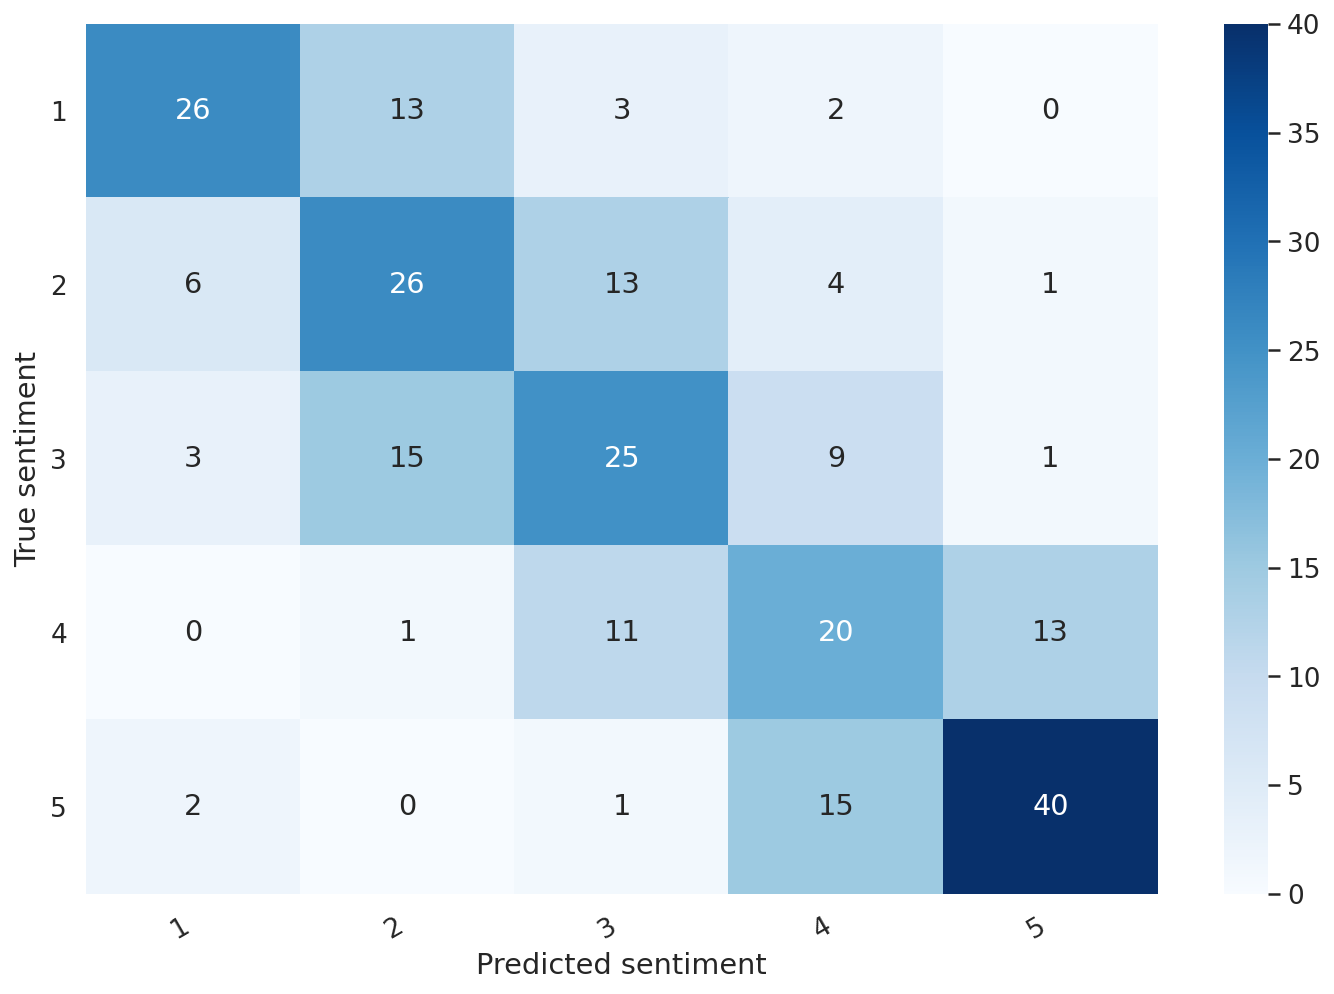

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That's a good overview of the performance of our model. But let's have a look at an example from our test data:

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

I got ripped off. This is NOT 10X. This is 3X at best! A cheap
magnifying glass, not worth the space it would take up in the junk
drawer.

True sentiment: 1


Now we can look at the confidence of each sentiment of our model:

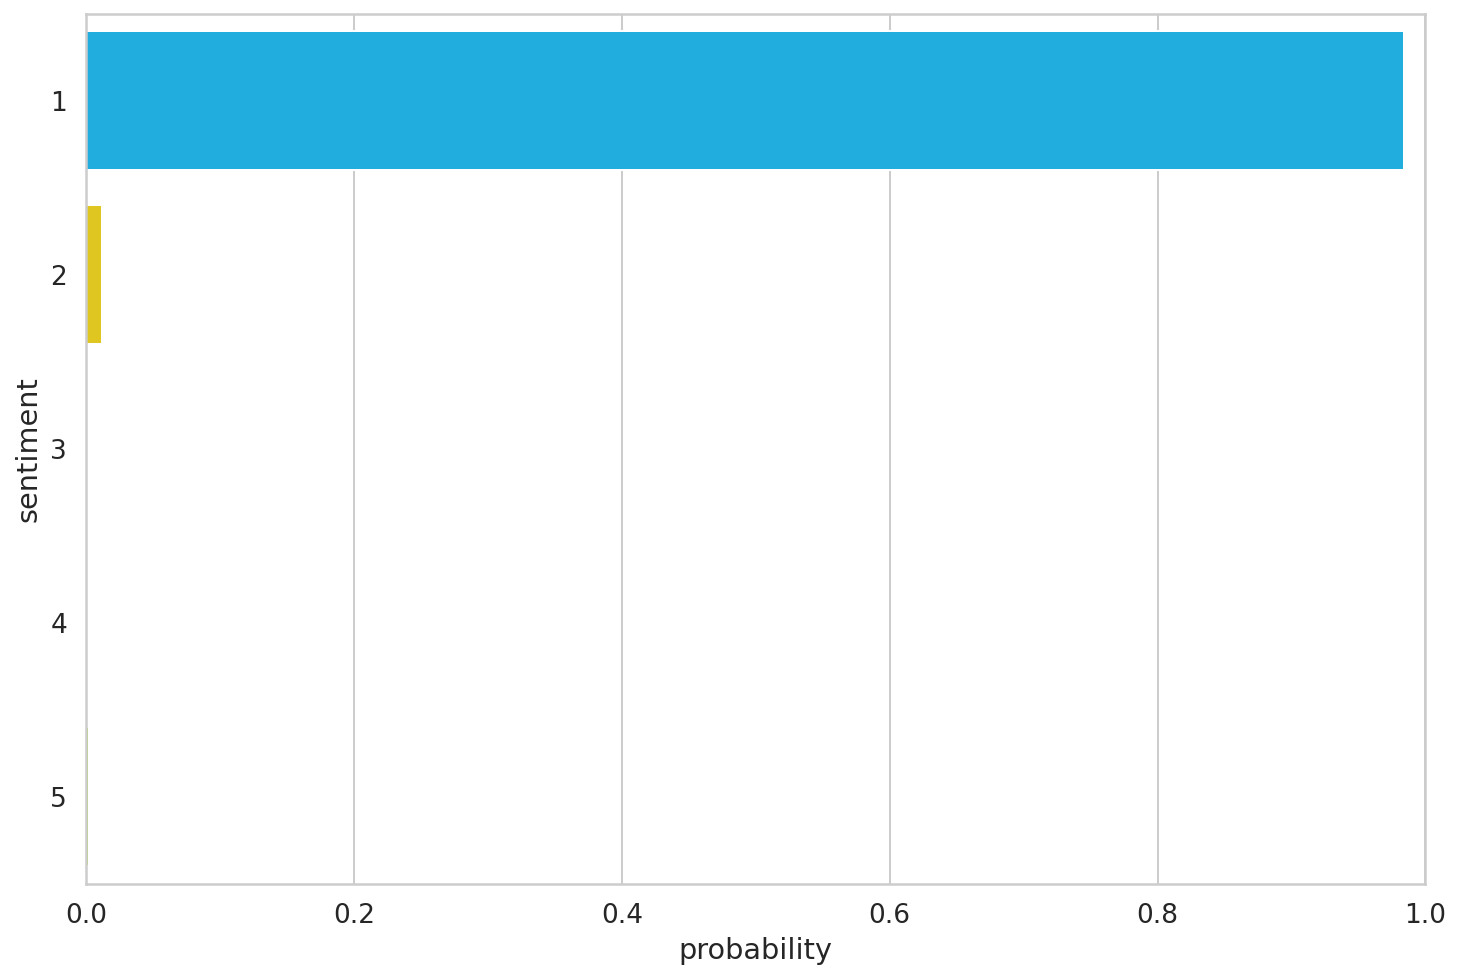

In [ ]:
sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
plt.ylabel('sentiment')
plt.xlabel('probability')
plt.xlim([0, 1]);

### Predicting on Raw Text

Let's use our model to predict the sentiment of some raw text:

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

We have to use the tokenizer to encode the text:

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'only_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you may want to check this is the right behavior.


Let's get the predictions from our model:

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I love completing my todos! Best app ever!!!
Sentiment  : 5


## OPTIMAL LEARNING RATE FINDER 

In [ ]:
!pip install torch-lr-finder

In [ ]:
from torch_lr_finder import LRFinder

In [ ]:
df_train_lr = df_train[['review_body', 'star_rating']]
df_train_lr

,review_body,star_rating
3716,Too small to be comfortable for a New Years Ev...,2
3779,"Good medium quality, washable. Would buy anoth...",2
135,Very happy with my purchase. It was an excelle...,4
4480,Takes like eight hours to charge my phone. Tri...,0
1437,Worked about half of the time.,1
...,...,...
4426,My dog is really picky. I got this and mix a l...,3
466,I love these sheets but they ripped down the m...,2
3092,Great picture. Had plenty of auxilary inputs o...,1
3772,Nice color just as pictured on site,4


In [ ]:
train_data_loader_lr = create_data_loader(df_train_lr, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
## Para lr_finder.range_test necesita un dataloader que sea tipo dict()
try:
    from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter
except ImportError:
    # Run from source
    import sys
    sys.path.insert(0, '..')
    from torch_lr_finder import LRFinder, TrainDataLoaderIter, ValDataLoaderIter


class CustomTrainIter(TrainDataLoaderIter):
    def inputs_labels_from_batch(self, batch_data):
        return batch_data["input_ids"], batch_data["targets"]
    
custom_train_iter_lr = CustomTrainIter(train_data_loader_lr)

LR suggestion: steepest gradient
Failed to compute the gradients, there might not be enough points.


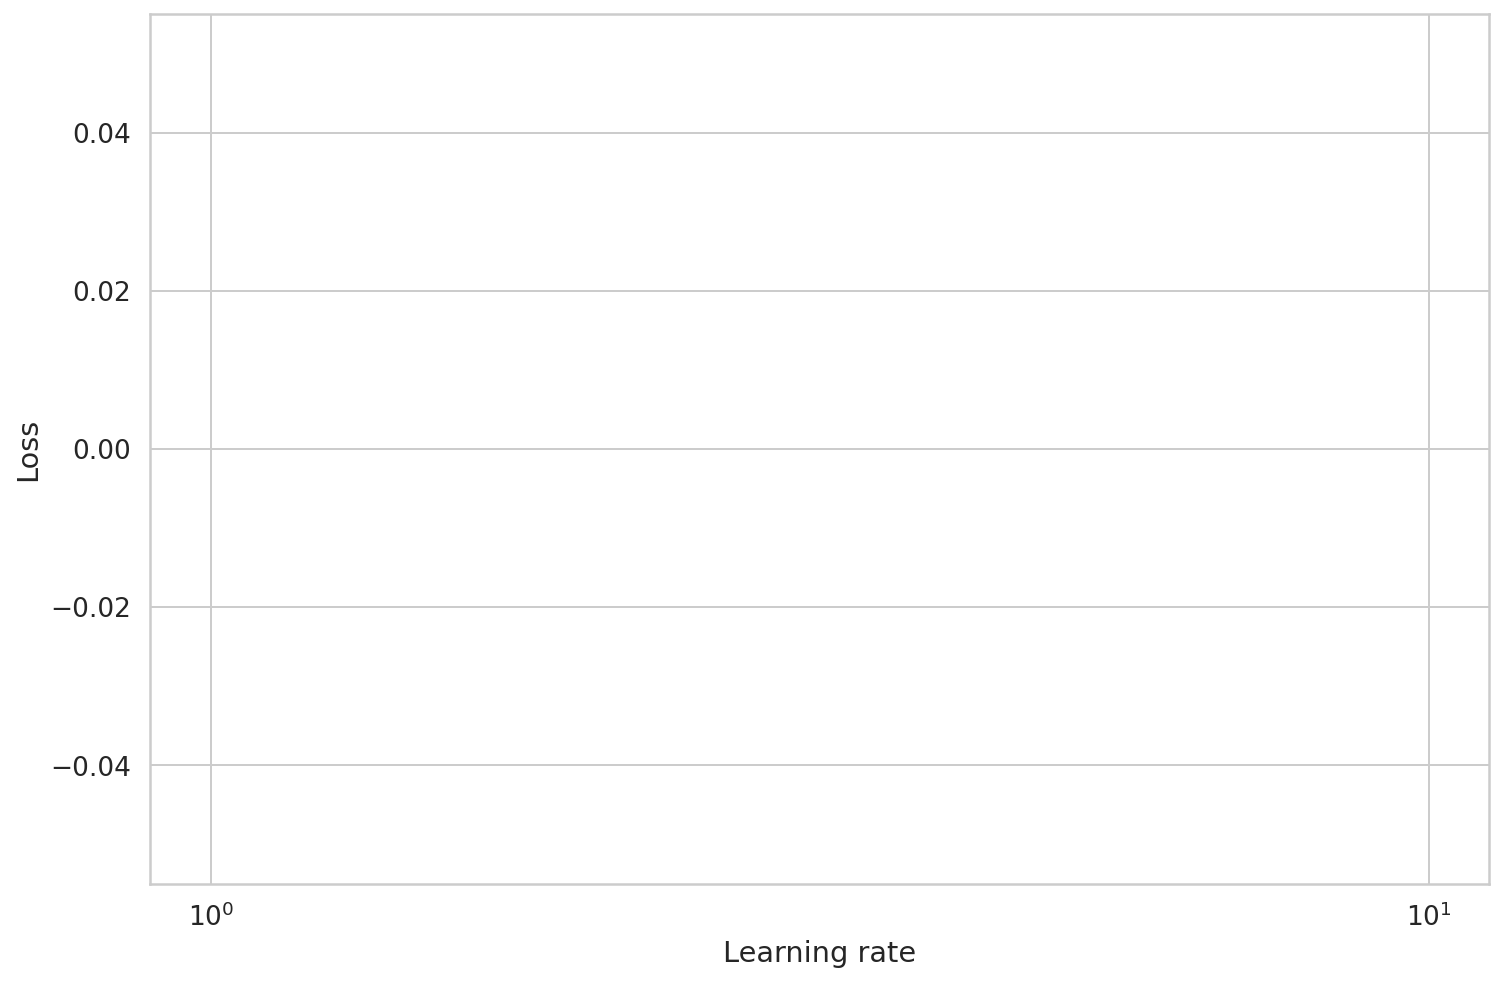

In [ ]:
## DEFINIMOS MODELO, CRITERIO, OPTIMIZER (algunos ya estaban definidos)

model = model
criterion = loss_fn
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
#optimizer = optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)

 
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
#lr_finder.range_test(custom_train_iter_lr, end_lr=100, num_iter=100)

lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state